In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split # Import train_test_split function
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [39]:
!pip install imbalanced-learn

In [3]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [4]:
df_train_final = pd.read_csv(r"C:\Users\sastr\6th sem\Internship\NSL_KDD\kdd_train_clean.csv")

In [5]:
df_test_final = pd.read_csv(r"C:\Users\sastr\6th sem\Internship\NSL_KDD\kdd_test_clean.csv")

## Standardization (Scaling) of features

In [6]:
X_train = df_train_final.drop(columns=['labels'])
y_train = df_train_final['labels']
X_test = df_test_final.drop(columns=['labels'])
y_test = df_test_final['labels']

In [9]:
#X_test['labels']

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Feature Selection

### Correlation between features

In [9]:
corr_matrix = df_train_final.drop(columns=['labels']).corr()


In [10]:
threshold = 0.9
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Print highly correlated pairs
for pair in highly_correlated_pairs:
    print(f"{pair[0]} - {pair[1]} : {pair[2]}")


num_root - num_compromised : 0.9988334525784719
srv_serror_rate - serror_rate : 0.9932892425370462
srv_rerror_rate - rerror_rate : 0.9890076529820762
dst_host_serror_rate - serror_rate : 0.979373082984311
dst_host_serror_rate - srv_serror_rate : 0.9775960119654399
dst_host_srv_serror_rate - serror_rate : 0.9811389586179897
dst_host_srv_serror_rate - srv_serror_rate : 0.9862517164931046
dst_host_srv_serror_rate - dst_host_serror_rate : 0.9850522227996314
dst_host_rerror_rate - rerror_rate : 0.9267485035758941
dst_host_rerror_rate - srv_rerror_rate : 0.9178223356828635
dst_host_srv_rerror_rate - rerror_rate : 0.9644486655034351
dst_host_srv_rerror_rate - srv_rerror_rate : 0.9702079974522381
dst_host_srv_rerror_rate - dst_host_rerror_rate : 0.9246878915781156
flag_5 - serror_rate : 0.9791740914923939
flag_5 - srv_serror_rate : 0.982659962260051
flag_5 - dst_host_serror_rate : 0.9758441112031959
flag_5 - dst_host_srv_serror_rate : 0.9812093528343018


In [11]:
threshold = 0.9
corr_features_to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            corr_features_to_drop.add(corr_matrix.columns[i])

print(corr_features_to_drop)

{'srv_serror_rate', 'flag_5', 'dst_host_srv_serror_rate', 'dst_host_serror_rate', 'num_root', 'srv_rerror_rate', 'dst_host_srv_rerror_rate', 'dst_host_rerror_rate'}


**Dropping the highly correlated columns**

In [12]:
X_train_reduced = X_train_scaled.drop(columns=corr_features_to_drop)
X_test_reduced = X_test_scaled.drop(columns=corr_features_to_drop)

### Highly correlated features with Target variable

In [14]:
corr_with_target = df_train_final.corr()['labels'].abs().sort_values(ascending=False)
print(corr_with_target)

labels                    1.000000
dst_host_srv_count        0.624241
logged_in                 0.576031
flag_9                    0.548643
dst_host_same_srv_rate    0.525829
                            ...   
urgent                    0.003941
land                      0.002944
is_host_login             0.002334
service_62                0.002296
num_outbound_cmds              NaN
Name: labels, Length: 123, dtype: float64


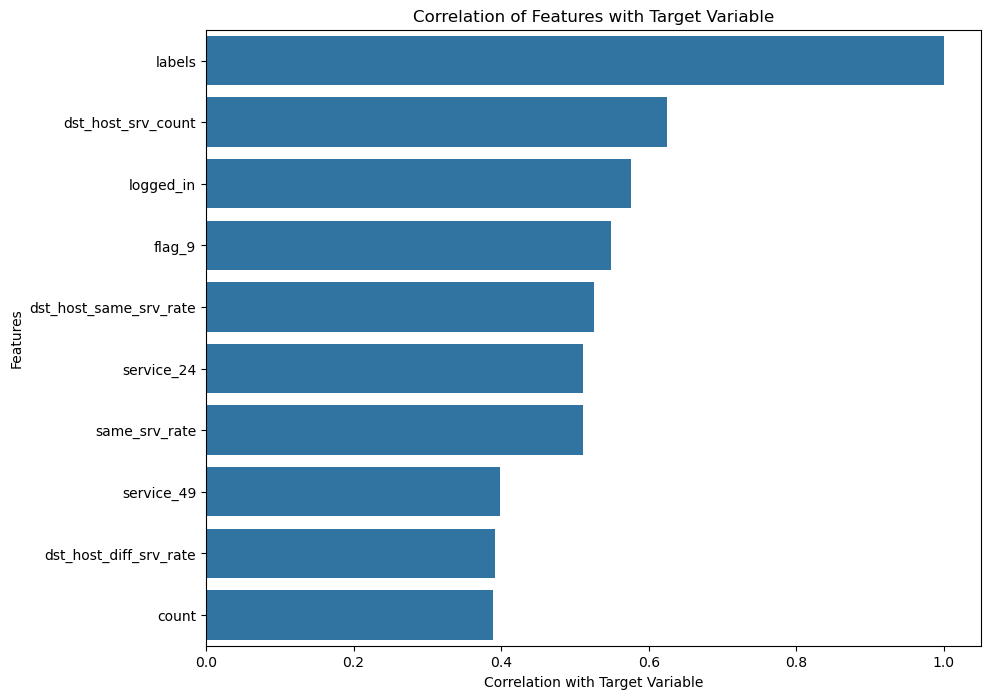

In [15]:
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values[:10], y=corr_with_target.index[:10], orient='h')
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Features')
plt.title('Correlation of Features with Target Variable')
plt.show()


## Feature Importance using Random Forest

In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [25]:
importances = rf.feature_importances_
feature_names = X_train_reduced.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
#print(feature_importances)

for index, row in feature_importances.iterrows():
    print(row['feature'], "-->", row['importance'])

src_bytes --> 0.13343620736767609
flag_9 --> 0.08017254433219688
count --> 0.07027203264113552
diff_srv_rate --> 0.07000385388448689
dst_host_same_srv_rate --> 0.06457463218030234
same_srv_rate --> 0.06389703014118589
dst_bytes --> 0.053936714010207075
serror_rate --> 0.05064445353179795
dst_host_srv_count --> 0.04585166859308468
dst_host_diff_srv_rate --> 0.04490275043380693
dst_host_same_src_port_rate --> 0.035069199542766646
srv_count --> 0.031170407681331884
logged_in --> 0.030111009174386933
dst_host_count --> 0.026032483219522038
dst_host_srv_diff_host_rate --> 0.021670615684399857
protocol_type_0 --> 0.020025981277187053
service_24 --> 0.018195762799112194
service_14 --> 0.0161999279650188
service_49 --> 0.013449578099592092
protocol_type_1 --> 0.013127462305231088
service_15 --> 0.012512152990947776
srv_diff_host_rate --> 0.011720425677020673
rerror_rate --> 0.010392077678827433
wrong_fragment --> 0.007350397029863802
hot --> 0.007207092920713829
num_compromised --> 0.006739925

**Cumulative importance to extract the number of important features as a whole**

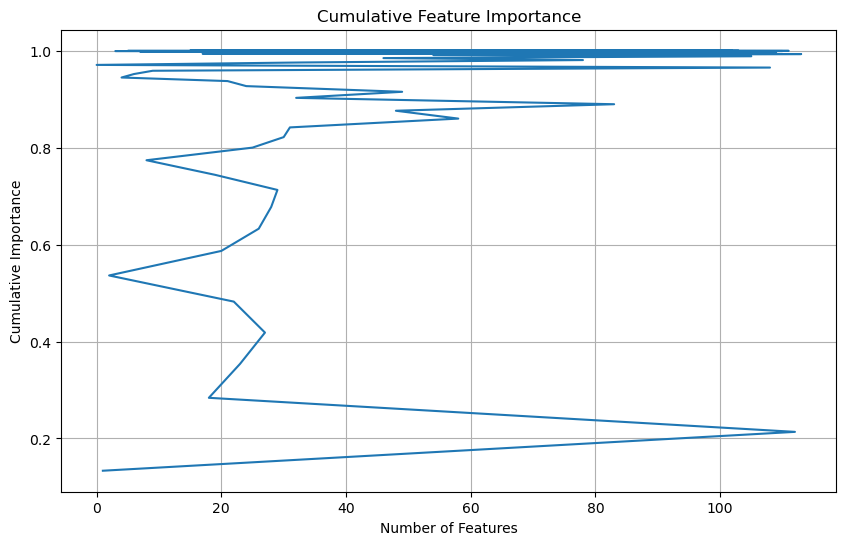

In [26]:
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()
plt.figure(figsize=(10, 6))
plt.plot(feature_importances['cumulative_importance'])
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid()
plt.show()

In [29]:
threshold = 0.95  # Set your threshold
cumulative_importance = feature_importances['cumulative_importance']
num_features_to_retain = cumulative_importance[cumulative_importance <= threshold].shape[0]
print(f"Number of features to retain for {threshold*100}% cumulative importance: {num_features_to_retain}")
# Filter the top features
selected_features = feature_importances.iloc[:num_features_to_retain]['feature'].values
print(f"Selected features: {selected_features}")


Number of features to retain for 95.0% cumulative importance: 24
Selected features: ['src_bytes' 'flag_9' 'count' 'diff_srv_rate' 'dst_host_same_srv_rate'
 'same_srv_rate' 'dst_bytes' 'serror_rate' 'dst_host_srv_count'
 'dst_host_diff_srv_rate' 'dst_host_same_src_port_rate' 'srv_count'
 'logged_in' 'dst_host_count' 'dst_host_srv_diff_host_rate'
 'protocol_type_0' 'service_24' 'service_14' 'service_49'
 'protocol_type_1' 'service_15' 'srv_diff_host_rate' 'rerror_rate'
 'wrong_fragment']


In [34]:
X_train_selected = pd.DataFrame(X_train_reduced[selected_features], columns=selected_features)
X_test_selected = pd.DataFrame(X_test_reduced[selected_features], columns=selected_features)

In [36]:
X_train_selected.head()


,src_bytes,flag_9,count,diff_srv_rate,dst_host_same_srv_rate,same_srv_rate,dst_bytes,serror_rate,dst_host_srv_count,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,protocol_type_0,service_24,service_14,service_49,protocol_type_1,service_15,srv_diff_host_rate,rerror_rate,wrong_fragment
0,-0.007679,0.825150,-0.717045,-0.349683,-0.782367,0.771283,-0.004919,-0.637209,-0.818890,-0.280282,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.458130,0.476175,-0.158232,-0.374560,-0.374362,-0.089486
1,-0.007737,0.825150,-0.620982,0.482201,-1.161030,-1.321428,-0.004919,-0.637209,-1.035688,2.736852,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.458130,-2.100067,-0.158232,-0.374560,-0.374362,-0.089486
2,-0.007762,-1.211901,0.339648,0.038529,-0.938287,-1.389669,-0.004919,1.602664,-0.809857,-0.174417,...,-0.289103,-0.265429,-0.686328,-0.194371,2.182788,0.476175,-0.158232,-0.374560,-0.374362,-0.089486
3,-0.007723,0.825150,-0.690846,-0.349683,1.066401,0.771283,-0.002891,-0.189235,1.258754,-0.439078,...,0.066252,-0.265429,1.457030,-0.194371,-0.458130,0.476175,-0.158232,-0.374560,-0.374362,-0.089486
4,-0.007728,0.825150,-0.472521,-0.349683,1.066401,0.771283,-0.004814,-0.637209,1.258754,-0.439078,...,-0.289103,-0.265429,1.457030,-0.194371,-0.458130,0.476175,-0.158232,-0.028179,-0.374362,-0.089486


In [38]:
X_test_selected.head()

,src_bytes,flag_9,count,diff_srv_rate,dst_host_same_srv_rate,same_srv_rate,dst_bytes,serror_rate,dst_host_srv_count,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,protocol_type_0,service_24,service_14,service_49,protocol_type_1,service_15,srv_diff_host_rate,rerror_rate,wrong_fragment
0,-0.007348,0.825150,-0.725778,-0.349683,-0.916013,0.771283,-0.004801,-0.637209,-0.529826,-0.333214,...,0.066252,-0.265429,-0.686328,-0.194371,-0.45813,0.476175,-0.158232,-0.374560,-0.374362,-0.089486
1,-0.007755,0.825150,0.942225,-0.294224,0.620915,0.748536,-0.004885,-0.637209,0.355431,-0.333214,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.45813,-2.100067,-0.158232,-0.336073,-0.374362,-0.089486
2,-0.007755,0.825150,0.322182,-0.349683,1.066401,0.771283,-0.004899,-0.637209,1.258754,-0.439078,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.45813,-2.100067,-0.158232,-0.374560,-0.374362,-0.089486
3,-0.007738,0.825150,-0.717045,-0.349683,-1.138756,0.771283,-0.004893,-0.637209,-1.026654,4.007224,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.45813,-2.100067,-0.158232,-0.374560,-0.374362,-0.089486
4,-0.007762,-1.211901,-0.717045,-0.349683,-1.138756,0.771283,-0.004919,-0.637209,-1.026654,3.160309,...,-0.289103,-0.265429,-0.686328,-0.194371,-0.45813,0.476175,-0.158232,-0.374560,2.746403,-0.089486


# DSSTE Algorithm

**ENN - Identifying easy and difficult instances**

In [41]:
# Initialize ENN
enn = EditedNearestNeighbours()

# Fit and apply ENN
X_easy, y_easy = enn.fit_resample(X_train_selected, y_train)

#find difficult instances by set difference with easy examples
mask_easy = enn.sample_indices_
mask_difficult = np.setdiff1d(np.arange(len(X_train_selected)), mask_easy)

X_difficult = X_train_selected.iloc[mask_difficult]
y_difficult = y_train.iloc[mask_difficult]

# Print shapes to verify
print("Easy set shape:", X_easy.shape)
print("Difficult set shape:", X_difficult.shape)


Easy set shape: (123876, 24)
Difficult set shape: (2097, 24)


**KMeans - Compressing majority samples in difficult set**

In [43]:
#identify majority class
majority_class = y_difficult.value_counts().idxmax()

X_majority_difficult = X_difficult[y_difficult == majority_class]
y_majority_difficult = y_difficult[y_difficult == majority_class]
print("Majority class difficult set shape:", X_majority_difficult.shape)

Majority class difficult set shape: (1145, 24)


In [44]:
# Define the number of clusters (e.g., compress to 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_majority_difficult)

X_compressed_majority = pd.DataFrame(kmeans.cluster_centers_, columns=X_majority_difficult.columns)
y_compressed_majority = pd.Series([majority_class] * num_clusters, name='labels')

print("Compressed majority set shape:", X_compressed_majority.shape)

Compressed majority set shape: (10, 24)


In [58]:
y_compressed_majority.value_counts()

labels
0    10
Name: count, dtype: int64

**SMOTE - Increase the number of minority samples in difficult set**

In [61]:
y_difficult.value_counts()

labels
0    1145
1     387
3     381
2     184
Name: count, dtype: int64

In [60]:
#removing instances of class 0
X_minority_difficult = X_difficult[y_difficult != majority_class]
y_minority_difficult = y_difficult[y_difficult != majority_class]

In [62]:
y_minority_difficult.value_counts()

labels
1    387
3    381
2    184
Name: count, dtype: int64

In [63]:
majority_count = y_difficult.value_counts()[0] #1145

#
smote = SMOTE(sampling_strategy={1: majority_count, 2: majority_count, 3: majority_count}, random_state=42)
X_augmented_minority, y_augmented_minority = smote.fit_resample(X_minority_difficult, y_minority_difficult)


print("Augmented minority set shape:", X_augmented_minority.shape)
print("Class distribution after SMOTE:")
print(y_augmented_minority.value_counts())

Augmented minority set shape: (3435, 24)
Class distribution after SMOTE:
labels
3    1145
1    1145
2    1145
Name: count, dtype: int64


**Combining easy set, compressed majority and augmented minority**

In [64]:
X_train_balanced = pd.concat([X_easy, X_compressed_majority, X_augmented_minority])
y_train_balanced = pd.concat([pd.Series(y_easy, name='labels'), y_compressed_majority, pd.Series(y_augmented_minority, name='labels')])

In [71]:
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [72]:
print("Balanced training set shape:", X_train_balanced.shape)

Balanced training set shape: (127321, 24)


In [73]:
# Check for null values in X_train_balanced
null_counts_X = X_train_balanced.isnull().sum()

# Check for null values in y_train_balanced
null_counts_y = y_train_balanced.isnull().sum()

# Check if any null values exist
if null_counts_X.any() or null_counts_y.any():
    print("There are null values in the balanced training set.")
else:
    print("No null values found in the balanced training set.")

# Print shape to verify
print("Balanced training set shape:", X_train_balanced.shape)


No null values found in the balanced training set.
Balanced training set shape: (127321, 24)


**Saving the files**

In [76]:
train_file = r'C:\Users\sastr\6th sem\Internship\NSL_KDD\x_train_balanced.csv'
test_file = r'C:\Users\sastr\6th sem\Internship\NSL_KDD\x_test_selected.csv'
y_train_file = r'C:\Users\sastr\6th sem\Internship\NSL_KDD\y_train_balanced.csv'
y_test_file = r'C:\Users\sastr\6th sem\Internship\NSL_KDD\y_test.csv'

# Save X_train_balanced and X_test_selected
X_train_balanced.to_csv(train_file, index=False)
X_test_selected.to_csv(test_file, index=False)

# Save y_train_balanced and y_test
y_train_balanced.to_csv(y_train_file, index=False, header=True)  
y_test.to_csv(y_test_file, index=False, header=True)  

In [69]:
y_train.value_counts()

labels
0    67343
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

In [66]:
y_train_balanced.value_counts()

labels
0    66208
1    46685
2    12617
3     1759
4       52
Name: count, dtype: int64

In [57]:
y_easy.value_counts()

labels
0    66198
1    45540
2    11472
3      614
4       52
Name: count, dtype: int64

In [55]:
y_compressed_majority.value_counts()

labels
0    67343
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

In [67]:
y_augmented_minority.value_counts()

labels
3    1145
1    1145
2    1145
Name: count, dtype: int64

In [46]:
minority_classes = y_difficult.unique()

In [47]:
X_augmented_minority = []
y_augmented_minority = []

In [50]:
for minority_class in minority_classes:
    X_minority_difficult_class = X_difficult[y_difficult == minority_class]
    y_minority_difficult_class = y_difficult[y_difficult == minority_class]

    # Apply SMOTE to the current minority class
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_augmented_minority_class, y_augmented_minority_class = smote.fit_resample(X_minority_difficult_class, y_minority_difficult_class)

    # Append augmented samples to lists
    X_augmented_minority.append(X_augmented_minority_class)
    y_augmented_minority.append(y_augmented_minority_class)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [45]:
minority_class = y_difficult.value_counts().idxmin()

# Filter minority class samples
X_minority_difficult = X_difficult[y_difficult == minority_class]
y_minority_difficult = y_difficult[y_difficult == minority_class]

# Print shape to verify
print("Minority class difficult set shape:", X_minority_difficult.shape)

Minority class difficult set shape: (184, 24)


In [80]:
import imblearn

print(imblearn.__version__)

0.11.0
